# Importing Libraries

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt; plt.style.use('ggplot') 
import seaborn as sns;
import warnings; warnings.filterwarnings('ignore')
import scipy.io as io
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve,roc_curve, confusion_matrix
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import auc, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle

# Loading Data

In [2]:
# Loading the datatset
data =  io.loadmat("../data/raw/emails.mat")
print('# obervations:',data['X'].shape)
print('# class observations:',data['Y'].shape)

# obervations: (57173, 10000)
# class observations: (1, 10000)


# Data Exploration

## exploring labels

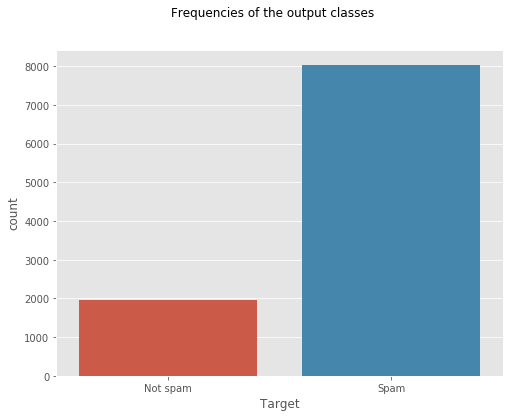

<Figure size 432x288 with 0 Axes>

In [3]:
# plot the frequencies of the classes
YData = pd.DataFrame(data['Y'].T)
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x = YData[0], ax=ax)
ax.set_xticklabels(['Not spam','Spam'])
ax.set_xlabel('Target')
fig.suptitle('Frequencies of the output classes')
plt.show()
plt.savefig('../reports/frequencies_class_distribution.png', bbox_inches='tight')

## exploring features

In [20]:
sparse_matrix = csr_matrix(data['X'])
#Converting the sparse matrix to a dense matrix
dense_matrix = sparse_matrix.todense()  
# N.B.:This operation is computationally expensive, 
#so we'll perform it just once to explore the data
print('*'*50)
print('Sparcity of the matrix')
print('*'*50)
#calculating sparcity of the matrix
sparcity = 1-(np.count_nonzero(dense_matrix) / float(dense_matrix.size))        
print(sparcity)
df = pd.DataFrame(dense_matrix.T)

**************************************************
Sparcity of the matrix
**************************************************
0.9958870463330594


In [5]:
# Converting to dataframe for easier operation
# displaying first few rows
df = pd.DataFrame(dense_matrix.T)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,57163,57164,57165,57166,57167,57168,57169,57170,57171,57172
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# checking the ranges in the word count for each word
print(df[322].value_counts())
print(df[2848].value_counts())

0.0    9867
1.0     133
Name: 322, dtype: int64
0.0    9991
1.0       8
2.0       1
Name: 2848, dtype: int64


In [7]:
# Calculating the word frequencies of different words in feature set
words_frequency = np.sum(df, axis=0)
word_freq_df= pd.DataFrame(data=words_frequency, columns=['Word Count'])
word_freq_df['Word Id']=word_freq_df.index
word_freq_df=word_freq_df.reset_index(drop=True)
word_freq_df=word_freq_df.set_index('Word Id')
# some words have occured more often
word_freq_df.sort_values(by='Word Count',ascending=False).head()

,Word Count
Word Id,
46208,75793.0
46434,63806.0
54075,55856.0
4148,52935.0
12835,52705.0


In [8]:
# some occured less
word_freq_df.sort_values(by='Word Count',ascending=False).tail()

,Word Count
Word Id,
6463,2.0
25459,2.0
33595,2.0
50438,2.0
38637,2.0


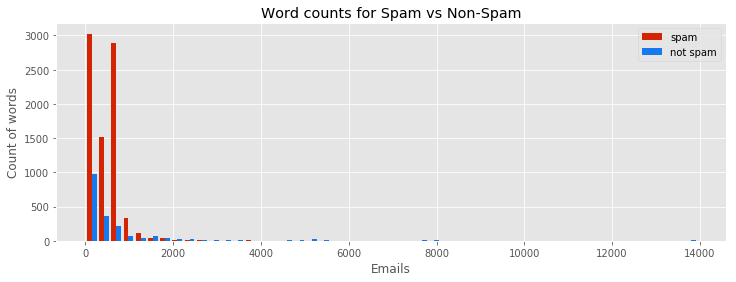

In [9]:
# Plotting for understanding the word count distribution of spam/Ham emails
len_emails = np.sum(df, axis=1)
y_values = np.array(data['Y'][0])
len_spam = len_emails[y_values==1]
len_not_spam = len_emails[y_values==-1]

plt.figure(figsize=(12,4))
plt.hist([len_spam, len_not_spam], bins=50, color=['#D32404', '#1779EE'],
         label=['spam', 'not spam'],density=False)
plt.title('Word counts for Spam vs Non-Spam')
plt.xlabel('Emails')
plt.ylabel('Count of words')
plt.legend()
plt.savefig('../reports/Length_distribution_based_on_category.png', 
            bbox_inches='tight')

# Data preparation

In [10]:
# Preparing data for further operations
X = data['X'].T
y = data['Y']

In [11]:
def upsampling(X,y):
    """ Balance the class instances using upsampling the minority class
        
        Parameters
        ------------
        X: array
            Features 
        y: array
            Labels
        
        Returns
        --------------
        tuple
            Returns new features and labels
    """
    from sklearn.utils import resample
    from scipy.sparse import vstack
    #Separating the samples with class '-1' from X
    minorityClassX= X[y[0] == -1,:] 
    #Separating the samples with class '1' from X
    majorityClassX= X[y[0] == 1,:]                    
    
    print(minorityClassX.shape)
    print(majorityClassX.shape)

    resampledMinorityClassX= resample(minorityClassX,replace=True,n_samples=8030)
    newSparseMatrix = vstack([majorityClassX,resampledMinorityClassX])
    #Separating the samples with class '-1' from Y
    minorityClassY= y.T[y[0] == -1]   
    #Separating the samples with class '1' from Y
    majorityClassY= y.T[y[0] == 1]                                  

    newMinorityClassValueY = np.full((len(majorityClassY), 1), -1)
    #Creating new Y value with balanced '1' and '-1'
    newYValue = np.vstack((majorityClassY,newMinorityClassValueY))  

    return newSparseMatrix, newYValue

In [12]:
# Upsampling the minority class

X_upsample,y_upsample=upsampling(X,y)
print('# observations:',X_upsample.shape)
print("# labels:",y_upsample.shape)
print("# Not spam:",len(np.where(y_upsample==-1)[0]))
print('# Spam:',len(np.where(y_upsample==1)[0]))

(1970, 57173)
(8030, 57173)
# observations: (16060, 57173)
# labels: (16060, 1)
# Not spam: 8030
# Spam: 8030


In [13]:
# Normalizing the data

from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_upsample_tfidf= transformer.fit_transform(X_upsample)
print('# observations:',X_upsample_tfidf.shape)

# observations: (16060, 57173)


# Training

In [14]:
def adjusted_classes(y_scores, t):
    """
    Predicts the classes based on the specifed threshold
    
    Parameters
    -----------
    y_scores: list
        Probabilites of the positive classes
    t: float
        Threshold 
    
    Returns
    -----------
    list
        Returns list of the predicted outcome
    """
    return [1 if y >= t else -1 for y in y_scores] 

In [15]:
def cross_validation(splits, X, Y, model, average_method='binary',t=0.5):
    ''' Performs k -fold cross validation and print the 
        classification report for each fold
        Parameter
        ---------
        splits: int
            Number of splits to be done
        X: array
            Feature set
        Y: array
            Labels
        model: Estimator
            Model to be trained on
        average_method: str
            method for the classification metrics (optional)
        t: float
            Defines the threshold
    '''
    from sklearn.model_selection import KFold
    kfold = KFold(n_splits=splits, shuffle=True, random_state=10)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    y_real = []
    y_proba = []

    fold=0
    #KFold Cross Validation so that the model performs good in future samples
    for train, test in kfold.split(X, Y):           
        fold=fold+1
        predictor = model.fit(X[train], Y[train])
        scores = predictor.score(X[test],Y[test])
        pred_proba =  predictor.predict_proba(X[test])
        # prediction of the classes based on threshold
        prediction = adjusted_classes(pred_proba[:,1], t)
        
        print('          Ham       Spam')

        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, 
                                         average=average_method)*100)
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('-'*50)
        
        # precision- recall curve for each folds
        precision_fold, recall_fold, thresh = precision_recall_curve(
            Y[test], pred_proba[:,1])

        pr_auc= auc(recall_fold,precision_fold)
        label_fold = 'Fold %d AUC=%.4f' % (fold, pr_auc)
        plt.plot(recall_fold, precision_fold, alpha=0.3, 
                 label=label_fold, color=np.random.rand(3,))

        y_real.append(Y[test])
        y_proba.append(pred_proba[:,1])
        
    # Report #
    # Prints the overall accuracy, precision and recall
    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    
    # plots the overall Precision-recall curve
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    precision, recall, threshold = precision_recall_curve(y_real, y_proba)
    final_label = 'Overall AUC=%.4f' % (auc(recall, precision))
    plt.plot(recall, precision, lw=2,color='red', label=final_label)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.legend(loc='lower left', fontsize='small')
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(threshold - t))
    plt.plot(recall[close_default_clf], precision[close_default_clf], '.', c='k',
            markersize=15)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-recall curve')
    plt.show()

          Ham       Spam
precision: [1.         0.98385093]
recall:    [0.98402948 1.        ]
--------------------------------------------------
          Ham       Spam
precision: [1.         0.98205742]
recall:    [0.98089172 1.        ]
--------------------------------------------------
          Ham       Spam
precision: [1.         0.98569726]
recall:    [0.98459564 1.        ]
--------------------------------------------------
          Ham       Spam
precision: [1.         0.98684211]
recall:    [0.98591549 1.        ]
--------------------------------------------------
          Ham       Spam
precision: [1.        0.9800995]
recall:    [0.9804401 1.       ]
--------------------------------------------------
          Ham       Spam
precision: [0.99877451 0.98734177]
recall:    [0.98787879 0.99871959]
--------------------------------------------------
          Ham       Spam
precision: [0.99874372 0.98765432]
recall:    [0.98757764 0.99875156]
---------------------------------

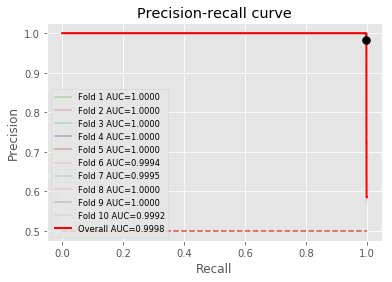

In [16]:
# logistic regression
lr = LogisticRegression(random_state=42)
cross_validation(10,X_upsample_tfidf,y_upsample,lr,t=0.2) 

          Ham       Spam
precision: [1.         0.99497487]
recall:    [0.995086 1.      ]
--------------------------------------------------
          Ham       Spam
precision: [1.         0.99635922]
recall:    [0.99617834 1.        ]
--------------------------------------------------
          Ham       Spam
precision: [1.         0.99399038]
recall:    [0.99358151 1.        ]
--------------------------------------------------
          Ham       Spam
precision: [1.         0.99158654]
recall:    [0.99103713 1.        ]
--------------------------------------------------
          Ham       Spam
precision: [1.         0.99494949]
recall:    [0.99511002 1.        ]
--------------------------------------------------
          Ham       Spam
precision: [1.         0.99617347]
recall:    [0.99636364 1.        ]
--------------------------------------------------
          Ham       Spam
precision: [0.99875467 0.99626401]
recall:    [0.99627329 0.99875156]
---------------------------------

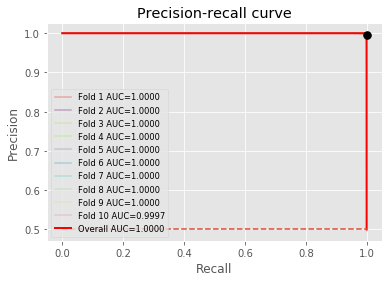

In [17]:
# random forest
rf = RandomForestClassifier(random_state=42)
cross_validation(10,X_upsample_tfidf,y_upsample,rf,t=0.2)

# Save the models

In [18]:
# save the best model for prediction to disk
filename = '../models/finalized_model_rf.sav'
pickle.dump(rf, open(filename, 'wb'))

# save the best model for prediction to disk
filename = '../models/finalized_model_lr.sav'
pickle.dump(lr, open(filename, 'wb'))

# Comment:

Both the models achieved high recall i.e. more than 99.8%. However, Random forest works better for the same threshold and also gave high AUC.